In [6]:
from ipythonblocks import BlockGrid
import random as rand
import numpy as np
import tempfile

from images2gif import writeGif
from PIL import Image
import os
import re
import sys

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function

GIF making code
---

In [7]:
def grid_to_rgb(grid):
    png=[]
    ishape=grid.shape[0]
    jshape=grid.shape[1]
    for i in range(ishape):
        col=[]
        for j in range(jshape):
            col.append(grid[j,i].rgb)
        png.append(col)
    png=np.array(png)
    return png

def make_png(array, size, fname='ipyim.png', show=True, save=True):
    newimage = Image.new('RGB', (len(array[0]), len(array)))  # type, size
    newimage.putdata([tuple(pixel) for row in array for pixel in row])
    newimage = newimage.resize(size, Image.LINEAR)
    if save==True:
        newimage.save(fname)  # takes type from filename extension
    if show == True:
        plt.imshow(newimage)
        plt.show()

In [8]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [9]:
def make_frames(num_frames,frame_size,directory,shape,dist,its,ints,T):
    
    grid=grid_init(shape,shape,dist,1)
    array=grid_to_rgb(grid)
    make_png(array,frame_size,directory+'/frame0.png',show=False)
    for i in range(1,num_frames):
        for it in range(its):
            grid=flip_grid(grid,T,shape,shape,ints)
        array=grid_to_rgb(grid)
        make_png(array,frame_size,directory+'/frame{0}.png'.format(i),show=False)

In [10]:
def make_gif(gifname,duration,directory,file_end,im_dimensions):
    file_names = sorted((fn for fn in os.listdir(directory) if fn.endswith(file_end)))
    #['frame0.png', 'frame1.png', 'frame2.png', ...] "
    file_names=natural_sort(file_names)
    images = [Image.open(directory+'/'+fn) for fn in file_names]
    
    for im in images:
        im.thumbnail(im_dimensions, Image.ANTIALIAS)

    writeGif(gif, images, duration)

Ising Model (from the book)
===

In [11]:
def grid_init(n,m,dist,size):
    grid = BlockGrid(n, m, fill=(0,0,0), block_size=size, lines_on=False)
    count=0
    for block in grid:
        num=rand.random()
        if num>=dist and num!=0.5:
            block.rgb = (255,255,255)
    return grid

def nghbr_spins(grid,i,j,ishape,jshape,S,ints):
    nS=0
    for n in range(0,ints):
        ishift,jshift=i+int(round(np.cos((2*n*np.pi)/ints),0)),j+int(round(np.sin((2*n*np.pi)/ints),0))
        if ishift!=ishape and jshift!=jshape:
            nS+=spin(grid[ishift,jshift].rgb)
        else:
            if i==ishape:
                nS+=spin(grid[0,jshift].rgb)
            if j==jshape:
                nS+=spin(grid[ishift,0].rgb)
    return nS

def spin(rgb):
    if rgb==(255,255,255):
        return -1
    else:
        return 1
    
def flip_grid(grid,T,ishape,jshape,ints):
    
    i=rand.randrange(0,ishape)
    j=rand.randrange(0,jshape)
    rgb_S=grid[i,j].rgb
    S=spin(rgb_S)
    nS=nghbr_spins(grid,i,j,ishape,jshape,S,ints)

    U_diff=2*S*nS
    #print(nS,S,U_diff)
    if U_diff<=0:
        #print(True)
        grid[i,j].rgb=abs(np.array(rgb_S)-255)
    else:
        if rand.random()<np.exp(-U_diff/T):
            grid[i,j].rgb=abs(np.array(rgb_S)-255)
    return grid

In [12]:
def ising_frame(grid,T,ishape,jshape,its,ints,frm):
    
    U2_avg=0
    U_avg=0
    S_avg=0
    count=0
    N=ishape*jshape
    
    for n in range(its):
        grid=flip_grid(grid,T,ishape,jshape,ints)
        for i in range(ishape):
            for j in range(jshape):
                rgb_S=grid[i,j].rgb
                S=spin(rgb_S)
                nS=nghbr_spins(grid,i,j,ishape,jshape,S,ints)
                E=-2*S*nS
                U2_avg+=E**2
                U_avg+=E
                S_avg+=S
                count+=1
        
        if round(float(n)/its*100,2)%10==0:
            st='frame {0} -- {1}% complete -- U_avg = {2}'
            print(st.format(frm+1,format(round(float(n)/its*100,3),'.0f'),format(float(U_avg)/N/(1+n),'.6f')),end='\r')
    return grid,float(U_avg)/N/its,float(U2_avg)/N/its,float(S_avg)/N/its

In [13]:
def ising_lists(Ti,Tf,dist,frames,its,ints,ishape,jshape,size):
    T=Ti
    dT=float(Tf-Ti)/frames
    grid=grid_init(ishape,jshape,dist,size)
    T_l=[]
    Uavg_l=[]
    U2avg_l=[]
    Savg_l=[]
    for frm in range(frames):
        grid,Uavg,U2avg,Savg=ising_frame(grid,T,ishape,jshape,its,ints,frm)
        T+=dT
        Uavg_l.append(Uavg)
        U2avg_l.append(U2avg)
        Savg_l.append(Savg)
        T_l.append(T)
    return T_l,Uavg_l,U2avg_l,Savg_l

In [17]:
def ising_mag(grid,T,ishape,jshape,its,ints,frm,t):

    S_avg=0
    N=ishape*jshape
    
    for n in range(its):
        grid=flip_grid(grid,T,ishape,jshape,ints)
        for i in range(ishape):
            for j in range(jshape):
                S=spin(grid[i,j].rgb)
                S_avg+=S
        if round(float(n)/its*100,2)%10==0:
            st='T = {2} -- frame {0} -- {1}% complete\r'
            print(st.format(frm+1,format(round(float(n)/its*100,3),'.0f'),format(t,'.3f'),format(float(S_avg)/N/(n+1),'.3f')),end='\r')
    return grid,float(S_avg)/N/its

In [15]:
def Es_to_Cv(T,E,E2):
    C=[]
    for i in range(len(T)):
        C.append(float(E2[i]-E[i]**2)/T[i]**2)
    return C

GIF frames
---

#5x5


In [1]:
#T_5,Uavg_5,Uavg2_5,Savg_5=ising_lists(1,5,0,100,6000,4,5,5,1)

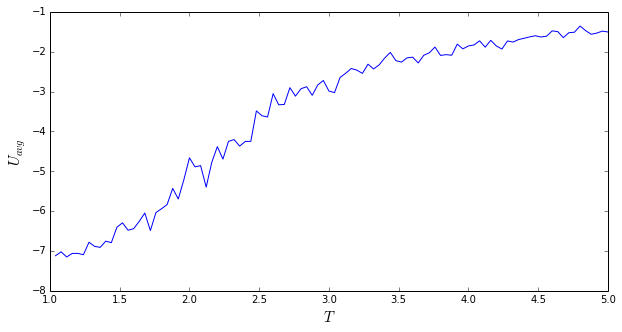

In [16]:
plt.figure(figsize=(10,5))
plt.plot(T_5,Uavg_5)
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$U_{avg}$',fontsize=15)
plt.xlim(1,5)
plt.show()

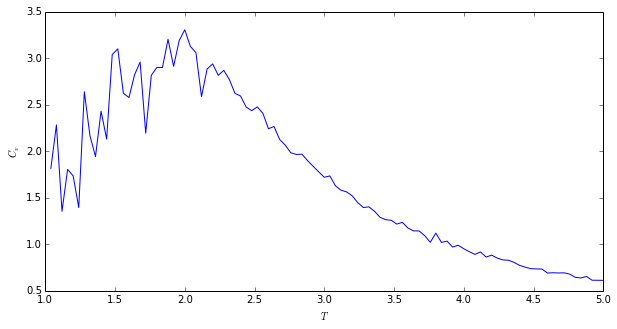

In [17]:
Cv_5=Es_to_Cv(T_5,Uavg_5,Uavg2_5)
plt.figure(figsize=(10,5))
plt.plot(T_5,Cv_5)
plt.xlabel(r'$T$')
plt.ylabel(r'$C_v$')
plt.xlim(1,5)
plt.show()

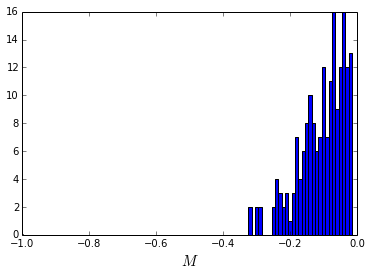

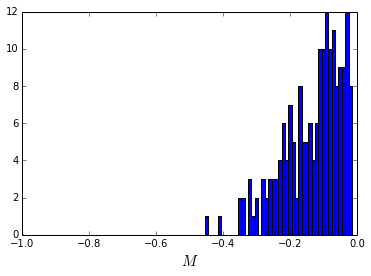

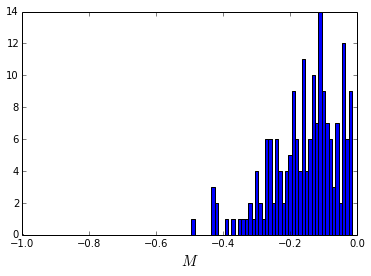

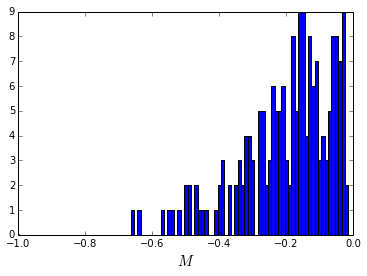

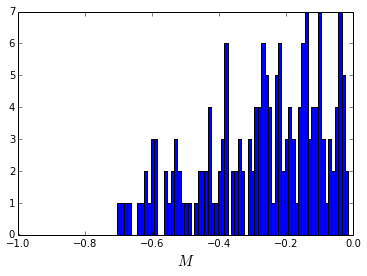

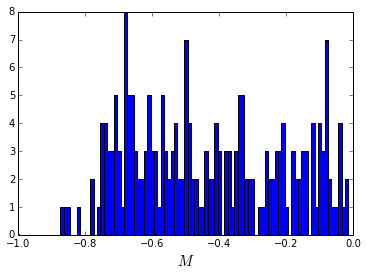

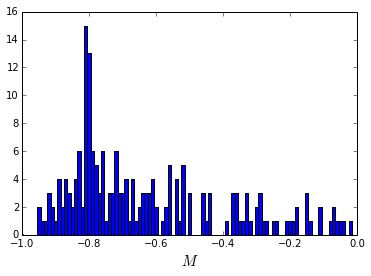

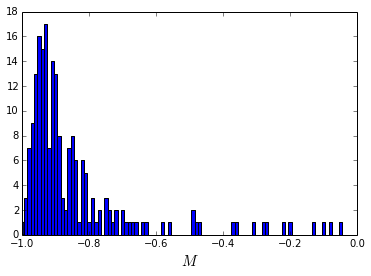

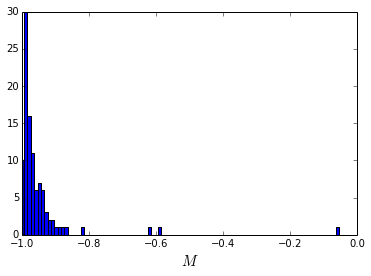

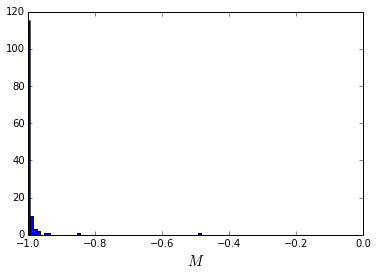

In [146]:
ishape=5
jshape=5
Ts=np.linspace(4,1,10)

num=400
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    plt.hist(Mag_tot,bins,align='left')
    plt.xlim(-1,0)
    plt.xlabel(r'$M$',fontsize=15)
    plt.show()

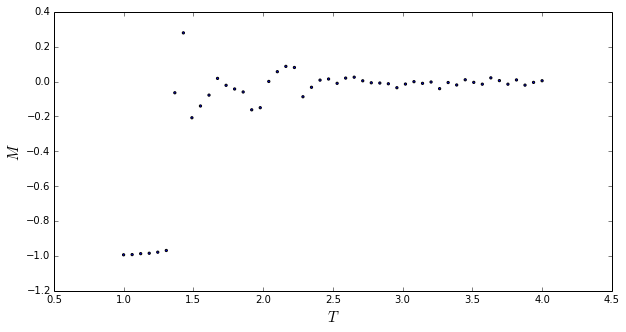

In [20]:
ishape=5
jshape=5
Ts=np.linspace(4,1,50)

num=100
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

count=0
Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    
    P=np.mean(Mag_tot)
    Prob_Mag5.append(P)
    
    
plt.figure(figsize=(10,5))
plt.scatter(Ts,Prob_Mag5,marker='.')
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$M$',fontsize=15)
plt.show()

26 a)

In [2]:
#make_frames(160,(500,500),'ising_pngs',40,0.5,1000,4,2.5)
#make_gif('Ising_Book_Mod/ising_Teq2.50.GIF',0.05,'ising_pngs','.png',(300,300))

26 c)

In [3]:
#make_frames(160,(500,500),'ising_pngs',20,0.5,1000,4,1.0)
#make_gif('Ising_Book_Mod/ising_Teq1.00.GIF',0.05,'ising_pngs','.png',(300,300))

26 d)

In [4]:
#make_frames(160,(500,500),'ising_pngs',10,0.5,1000,4,2.5)
#make_gif('Ising_Book_Mod/ising_Teq2.50.GIF',0.05,'ising_pngs','.png',(300,300))

26 e)

In [5]:
#make_frames(160,(500,500),'ising_pngs',10,0.5,1000,4,2.35)
#make_gif('Ising_Book_Mod/ising_Teq2.35.GIF',0.05,'ising_pngs','.png',(300,300))

In [6]:
#make_frames(160,(500,500),'ising_pngs',10,0.5,10000,4,2.27)
#make_gif('Ising_Book_Mod/ising_Teq2.27.GIF',0.05,'ising_pngs','.png',(300,300))

#10x10

In [7]:
#T_10,Uavg_10,Uavg2_10,Savg_10=ising_lists(1,5,0,100,3000,4,10,10,1)

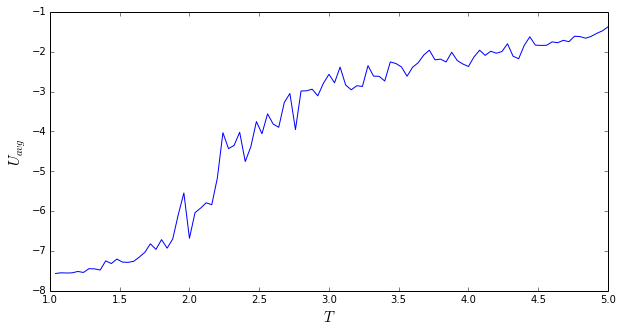

In [21]:
plt.figure(figsize=(10,5))
plt.plot(T_10,Uavg_10)
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$U_{avg}$',fontsize=15)
plt.xlim(1,5)
plt.show()

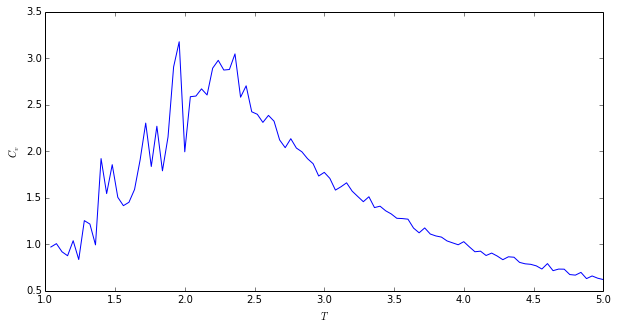

In [22]:
Cv_10=Es_to_Cv(T_10,Uavg_10,Uavg2_10)
plt.figure(figsize=(10,5))
plt.plot(T_10,Cv_10)
plt.xlabel(r'$T$')
plt.ylabel(r'$C_v$')
plt.xlim(1,5)
plt.show()

In [ ]:
ishape=10
jshape=10
Ts=np.linspace(4,1,50)

num=100
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    plt.hist(Mag_tot,bins,align='left')
    plt.xlim(-1,0)
    plt.xlabel(r'$M$',fontsize=15)
    plt.show()

In [ ]:
ishape=10
jshape=10
Ts=np.linspace(4,1,50)

num=30
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    
    P=np.mean(Mag_tot)
    Prob_Mag5.append(P)
    
plt.figure(figsize=(10,5))
plt.scatter(Ts,Prob_Mag5,marker='.')
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$M$',fontsize=15)
plt.show()

#20x20

In [23]:
#T_20,Uavg_20,Uavg2_20,Savg_20=ising_lists(1,3,0,75,2000,4,20,20,1)

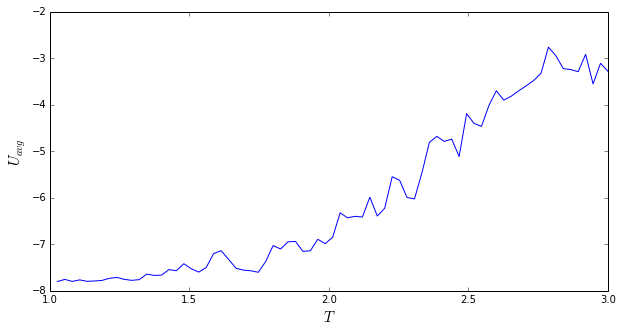

In [24]:
plt.figure(figsize=(10,5))
plt.plot(T_20,Uavg_20)
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$U_{avg}$',fontsize=15)
plt.xlim(1,3)
plt.show()

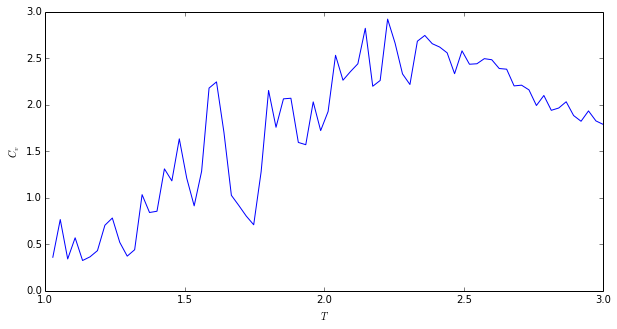

In [25]:
Cv_20=Es_to_Cv(T_20,Uavg_20,Uavg2_20)
plt.figure(figsize=(10,5))
plt.plot(T_20,Cv_20)
plt.xlabel(r'$T$')
plt.ylabel(r'$C_v$')
plt.xlim(1,3)
plt.show()

In [ ]:
ishape=20
jshape=20
Ts=np.linspace(4,1,6)

num=100
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    plt.hist(Mag_tot,bins,align='left')
    plt.xlim(-1,0)
    plt.xlabel(r'$M$',fontsize=15)
    plt.show()

In [ ]:
ishape=20
jshape=20
Ts=np.linspace(4,1,50)

num=30
bins=bins=np.arange(-1,0,0.01)
grid=grid_init(ishape,jshape,0.5,5)

Prob_Mag5=[]
for t in Ts:
    Mag_tot=[]
    for n in range(num):
        grid,mag=ising_mag(grid,t,ishape,jshape,1000,4,n,t)
        Mag_tot.append(mag)
    
    P=np.mean(Mag_tot)
    Prob_Mag5.append(P)
    
plt.figure(figsize=(10,5))
plt.scatter(Ts,Prob_Mag5,marker='.')
plt.xlabel(r'$T$',fontsize=15)
plt.ylabel(r'$M$',fontsize=15)
plt.show()